In [ ]:
import pandas as pd
from raimitigations.dataprocessing import Rebalance

df = pd.read_excel("/home/jui/thesis-code/data/credit_card_clients.xls")

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

In [3]:
df['EDUCATION'] = df['EDUCATION'].replace({1: 1, 2: 1, 3: 2, 4: 3})

In [4]:
# Count occurrences of each unique value across all PAY_* columns
value_counts = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].stack().value_counts()
# List of columns to modify
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Replace -2 with -1
df[pay_columns] = df[pay_columns].replace({-2:-1})

# Count occurrences of each unique value across PAY_* columns
value_counts = df[pay_columns].stack().value_counts()

# Print result
print(value_counts)


 0    95919
-1    59055
 2    18964
 1     3722
 3     1430
 4      453
 7      218
 5      137
 6       74
 8       28
dtype: int64


In [5]:
bins = [0, 25, 35, 45, 55, 70, float('inf')]  # Define bin edges
labels = [1, 2, 3, 4, 5, 6]  # Assign category labels

df['AGE'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False).astype(int)


In [6]:
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})
df = df.drop(columns=['ID'])
df['SEX'].value_counts()

rebalance = Rebalance(
				df=df,
				rebalance_col='SEX',
				k_neighbors=6,
				verbose=False
			)
df = rebalance.fit_resample()
print(df['SEX'].value_counts())

2    18112
1    18112
Name: SEX, dtype: int64


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from packaging import version
import sklearn
from sklearn.metrics import accuracy_score, classification_report

def split_label(dataset, target_feature):
    X = dataset.drop([target_feature], axis=1)
    y = dataset[[target_feature]]
    return X, y

# Handle different scikit-learn versions for OneHotEncoder parameters
if version.parse(sklearn.__version__) < version.parse('1.2'):
    ohe_params = {"sparse": False}
else:
    ohe_params = {"sparse_output": False}

def create_classification_pipeline(X):
    pipe_cfg = {
        'num_cols': X.dtypes[X.dtypes == 'int64'].index.values.tolist(),
        'cat_cols': X.dtypes[X.dtypes == 'object'].index.values.tolist(),
    }
    num_pipe = Pipeline([ 
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('cat_encoder', OneHotEncoder(handle_unknown='ignore', **ohe_params))
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols']),
        ('cat_pipe', cat_pipe, pipe_cfg['cat_cols'])
    ])

    xgb_model = xgb.XGBClassifier(
        tree_method='hist',  # Fast histogram-based training
        random_state=10,
        n_jobs=-1,  # Use all CPU cores
        learning_rate=0.16,  # Controls step size
        reg_lambda=1.1,  # L2 regularization (weight decay)
        eval_metric='logloss',
        objective='binary:logistic',  # Logarithmic loss for classification
        use_label_encoder=False,  # Avoids unnecessary warnings
        n_estimators=125
    )


    pipeline = Pipeline(steps=[('preprocessor', feat_pipe),
                               ('model', xgb_model)])

    return pipeline

/home/jui/.pyenv/versions/3.10.12/envs/myenv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:14:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Accuracy: 0.8417
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      7302
           1       0.66      0.37      0.48      1754

    accuracy                           0.84      9056
   macro avg       0.76      0.66      0.69      9056
weighted avg       0.82      0.84      0.82      9056


Final Training Log Loss: 0.2913
Final Test Log Loss: 0.3961


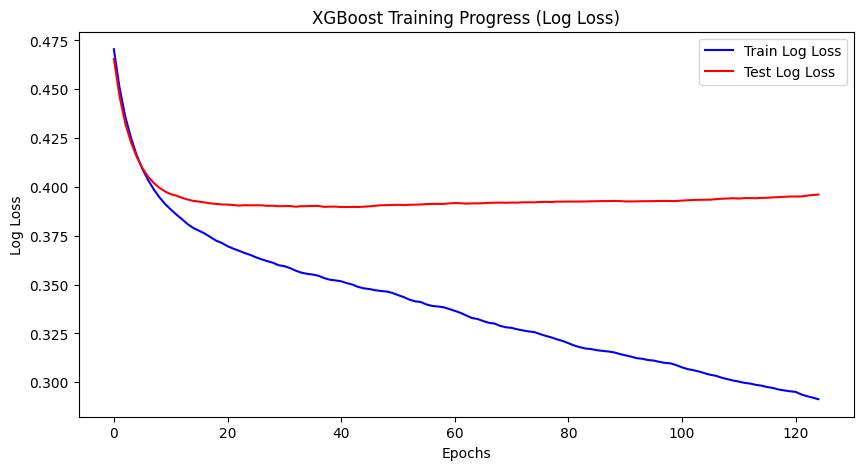

In [8]:
target_feature = 'default payment next month'
categorical_features = []

# Split data into features and target
X, y = split_label(df, target_feature)

# Split data into train and test sets (80% training, 20% testing)
X_train_og, X_test_og, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

# Create the classification pipeline
pipeline = create_classification_pipeline(X_train_og)

# Fit the preprocessor separately to extract feature names
pipeline.named_steps['preprocessor'].fit(X_train_og)

# Extract transformed feature names safely
if hasattr(pipeline.named_steps['preprocessor'], "get_feature_names_out"):
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
else:
    # Manually construct feature names (for older sklearn versions)
    num_cols = X_train_og.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X_train_og.select_dtypes(include=['object']).columns.tolist()
    feature_names = num_cols + cat_cols  # Not perfect, but works if get_feature_names_out() is missing

# Convert y_train and y_test to NumPy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Extract XGBClassifier separately and fit with eval_set
xgb_model = pipeline.named_steps['model']
xgb_model.fit(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train, 
              eval_set=[(pipeline.named_steps['preprocessor'].transform(X_train_og), y_train),
                        (pipeline.named_steps['preprocessor'].transform(X_test_og), y_test)], verbose=False)

# Make predictions
y_pred = xgb_model.predict(pipeline.named_steps['preprocessor'].transform(X_test_og))

# Compute accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}\n")

# Extract evaluation results
evals_result = xgb_model.evals_result()

# Get the final log loss for training and testing
train_log_loss = evals_result['validation_0']['logloss'][-1]
test_log_loss = evals_result['validation_1']['logloss'][-1]

# Print the final log loss values for both training and validation
print(f"Final Training Log Loss: {train_log_loss:.4f}")
print(f"Final Test Log Loss: {test_log_loss:.4f}")

# Plot training and validation log loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['logloss'], label='Train Log Loss', color='blue')
plt.plot(evals_result['validation_1']['logloss'], label='Test Log Loss', color='red')
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training Progress (Log Loss)")
plt.legend()
plt.show()